In [2]:
import numpy as np
import matplotlib.pyplot as plt

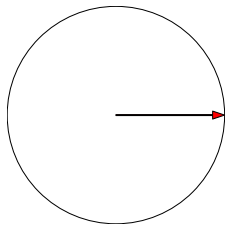

In [3]:
def simple_compass(yaw_degrees):
    # Convert degrees to radians for calculation
    yaw_radians = np.radians(yaw_degrees)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    # Draw the compass circle
    circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none')
    ax.add_patch(circle)

    # Calculate needle coordinates based on yaw
    end_x = np.sin(yaw_radians)
    end_y = np.cos(yaw_radians)

    # Draw the compass needle
    ax.annotate('', xy=(end_x, end_y), xytext=(0, 0),
                arrowprops=dict(facecolor='red', shrink=0, width=1, headwidth=8))

    # Hide axes
    ax.set_aspect('equal', 'box')
    ax.axis('off')

    plt.show()

# Example usage
simple_compass(90)  

In [2]:
import sys
import threading
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk
import xsensdeviceapi as xda
# from mpl_toolkits.mplot3d import Axes3D

# from omegaconf import OmegaConf

# from Init_det_glrt import Init_det_glrt
# from ZUPTaidedINS import ZUPTaidedINS
# from detector import detector_adaptive
# # from xda_utils import *
# from INS import INS

from threading import Lock

class Payload:
    def __init__(self):
        self.timestamp = []
        self.acc = np.array([0, 0, 0])
        self.angular_velocity = np.array([0, 0, 0])

class XdaCallback(xda.XsCallback):
    def __init__(self, max_buffer_size=5):
        super().__init__()
        self.m_maxNumberOfPacketsInBuffer = max_buffer_size
        self.m_packetBuffer = list()
        self.m_lock = Lock()

    def packetAvailable(self):
        with self.m_lock:
            return len(self.m_packetBuffer) > 0

    def getNextPacket(self):
        with self.m_lock:
            assert len(self.m_packetBuffer) > 0
            return xda.XsDataPacket(self.m_packetBuffer.pop(0))

    def onLiveDataAvailable(self, dev, packet):
        with self.m_lock:
            assert packet is not None
            if len(self.m_packetBuffer) >= self.m_maxNumberOfPacketsInBuffer:
                self.m_packetBuffer.pop(0)
            self.m_packetBuffer.append(xda.XsDataPacket(packet))

class Scanner:
    def __init__(self, retries=3, wait_time=1):
        self.control = xda.XsControl_construct()
        assert self.control != 0
        self.device = None
        self.retries = retries
        self.wait_time = wait_time

    def scan_and_open(self):
        attempt = 0
        while attempt < self.retries:
            print("Scanning for devices... Attempt:", attempt + 1)
            portInfoArray = xda.XsScanner_scanPorts()
            
            mtPort = xda.XsPortInfo()
            for i in range(portInfoArray.size()):
                if portInfoArray[i].deviceId().isMti() or portInfoArray[i].deviceId().isMtig():
                    mtPort = portInfoArray[i]
                    break
            
            if mtPort.empty():
                print("No MTi device found. Retrying...")
                attempt += 1
                time.sleep(self.wait_time)
                continue
            
            did = mtPort.deviceId()
            print(f"Found a device with ID: {did.toXsString()}, Port: {mtPort.portName()}")

            if not self.control.openPort(mtPort.portName(), mtPort.baudrate()):
                raise RuntimeError("Could not open port. Aborting.")
            
            self.device = self.control.device(did)
            assert self.device is not None
            print(f"Device {self.device.productCode()} with ID {self.device.deviceId().toXsString()} opened.")
            return self.device
        
        raise RuntimeError("No MTi device found after multiple attempts. Aborting.")

    def get_device_info(self):
        if self.device:
            device_info = {
                "Product Code": self.device.productCode(),
                "Device ID": self.device.deviceId().toXsString(),
                "Firmware Version": self.device.firmwareVersion().toXsString()
            }
            return device_info
        return {}

    def close(self):
        if self.device:
            self.device.stopRecording()
            self.device.closeLogFile()
        if self.control:
            self.control.close()
        print("Disconnected successfully.")

In [3]:
def process_data(data_packet):
    acc = data_packet.calibratedAcceleration()
    gyro = data_packet.calibratedGyroscopeData()
    # timestamp = data_packet.timeStamp().toMilliSeconds()
    return np.array([acc[0], acc[1], acc[2], gyro[0], gyro[1], gyro[2]])

In [4]:
scanner = Scanner()

In [5]:
device = scanner.scan_and_open()
callback = XdaCallback()
device.addCallbackHandler(callback)

Scanning for devices... Attempt: 1
Found a device with ID: 0388044D, Port: COM5
Device MTI-3-8A7G6 with ID 0388044D opened.


In [6]:
device.resetOrientation()

TypeError: resetOrientation() missing 1 required positional argument: 'resetmethod'

In [9]:
xda.XRM_Global  

4

In [3]:
import pandas as pd

if __name__ == '__main__':
    print("Creating XsControl object...")

    scanner = Scanner()
    try:
        device = scanner.scan_and_open()
        callback = XdaCallback()
        device.addCallbackHandler(callback)

        print("Putting device into configuration mode...")
        if not device.gotoConfig():
            raise RuntimeError("Could not put device into configuration mode. Aborting.")

        print("Configuring the device...")
        configArray = xda.XsOutputConfigurationArray()
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_PacketCounter, 0))
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_SampleTimeFine, 0))
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_Acceleration, 100))
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_RateOfTurn, 100))
        # configArray.push_back(xda.XsOutputConfiguration(xda.XDI_Timestamp, 100))

        if not device.setOutputConfiguration(configArray):
            raise RuntimeError("Could not configure the device. Aborting.")

        # List to store the collected data
        imu_data_list = []

        print("Putting device into measurement mode...")
        if not device.gotoMeasurement():
            raise RuntimeError("Could not put device into measurement mode. Aborting.")

        print("Starting recording...")
        if not device.startRecording():
            raise RuntimeError("Failed to start recording. Aborting.")

        print("Main loop. Recording data for 30 seconds.")
        startTime = xda.XsTimeStamp_nowMs()
        while xda.XsTimeStamp_nowMs() - startTime <= 30000:
            if callback.packetAvailable():
                packet = callback.getNextPacket()
                data = process_data(packet)
                imu_data_list.append(data)
                print(f"Acc X={data[1]:.2f}, Acc Y={data[2]:.2f}, Acc Z={data[3]:.2f}\r", end='', flush=True)

        print("\nStopping recording...")
        if not device.stopRecording():
            raise RuntimeError("Failed to stop recording. Aborting.")

        # Convert list to DataFrame and save to CSV
        columns = ["Acc X (m/s^2)", "Acc Y (m/s^2)", "Acc Z (m/s^2)", "Gyro X (deg/s)", "Gyro Y (deg/s)", "Gyro Z (deg/s)"]
        imu_data_df = pd.DataFrame(imu_data_list, columns=columns)
        imu_data_df.to_csv("imu_data.csv", index=False)
        print("Data saved to 'imu_data.csv'.")

        print("Closing log file...")
        if not device.closeLogFile():
            raise RuntimeError("Failed to close log file. Aborting.")

        print("Removing callback handler...")
        device.removeCallbackHandler(callback)

        scanner.close()

    except RuntimeError as error:
        print(error)
        sys.exit(1)
    except Exception as e:
        print(f"An unknown fatal error has occurred: {str(e)}. Aborting.")
        sys.exit(1)
    else:
        print("Successful exit.")


Creating XsControl object...
Scanning for devices... Attempt: 1
Found a device with ID: 0388044D, Port: COM5
Device MTI-3-8A7G6 with ID 0388044D opened.
Putting device into configuration mode...
Configuring the device...
Putting device into measurement mode...
Starting recording...
Main loop. Recording data for 30 seconds.
Acc X=4.09, Acc Y=9.58, Acc Z=0.020945
Stopping recording...
Data saved to 'imu_data.csv'.
Closing log file...
Removing callback handler...
Disconnected successfully.
Successful exit.
